Transfer learning refers to a technique where a pre-trained model, which has been trained on a large dataset for a particular task, is reused or adapted for a different but related task. Instead of starting the training process from scratch, transfer learning leverages the knowledge learned by the pre-trained model on the original task to improve performance on the new task, especially when the new task has a smaller dataset or computational constraints.

Multi-class weather dataset(MWD) for image classification is a valuable dataset. The dataset provides a platform for outdoor weather analysis by extracting various features for recognizing different weather conditions. <br>


https://data.mendeley.com/datasets/4drtyfjtfy/1

The easisest way is to download the dataset and rearrange each class images in seaparate folder in your OS, as I have done and will show you here 

In [7]:
import os

# Specify the path to the directory you want to display
directory_path = "C:/Users/Lenovo/Desktop/My Git Repo/PyTorch/PyTorch/data/Weather Data/dataset2"

# List the contents of the specified directory
directory_contents = os.listdir(directory_path)
print(directory_contents)

['Cloud', 'Rain', 'SunRise', 'SunShine']


In [43]:
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms , ToPILImage
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolder(root=directory_path, transform=transform)

In [28]:
print(dataset.classes)
class_names = dataset.classes

['Cloud', 'Rain', 'SunRise', 'SunShine']


The image is of Label: SunRise


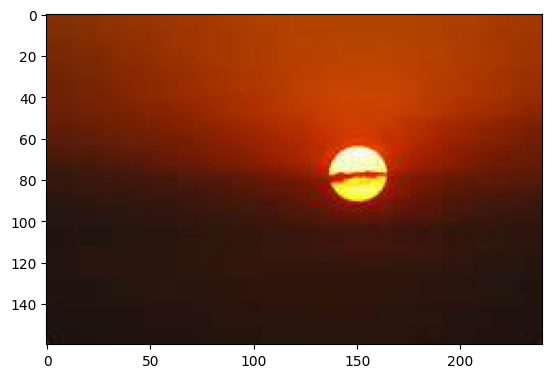

In [33]:
image, label = dataset[655]
toPil = ToPILImage()

print(f"The image is of Label: {class_names[label]}")
plt.imshow(toPil(image))


### PrePrcoessing

In [52]:
preprocess = transforms.Compose([
    transforms.Resize(256),        # Resize to 256x256
    transforms.CenterCrop(224),    # Crop the center to 224x224
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

dataset_Tesnor = ImageFolder(root=directory_path, transform=preprocess)

The image is of Label: SunRise


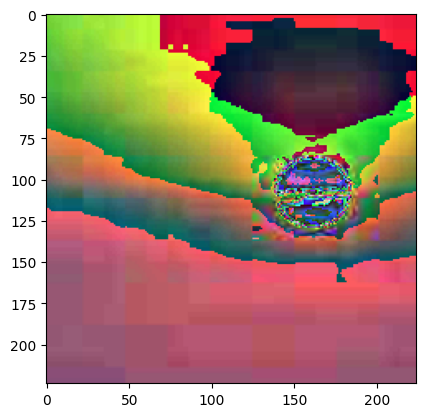

In [54]:
image, label = dataset_Tesnor[655]
toPil = ToPILImage()

print(f"The image is of Label: {class_names[label]}")
plt.imshow(toPil(image))

In [55]:
generator1 = torch.Generator().manual_seed(42)

train_size = int(0.8 * len(dataset_Tesnor))  # 80% of data for training
test_size = len(dataset_Tesnor) - train_size  # Remaining 20% for testing

train , test  = random_split(dataset_Tesnor,[train_size,test_size],generator1)

In [56]:
batch_size = 32  
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

### Using Transfer Learning Concept with SqueezeNet

In [34]:
squeezenet = models.squeezenet1_1(pretrained=True)

C:\Users\Lenovo\anaconda3\envs\dataml100\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\dataml100\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
squeezenet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

Incase you want to freeze parameters. Freeze all the parameters in the model<br>
for param in squeezenet.parameters():param.requires_grad = False
    

In [47]:
squeezenet.classifier[1] = nn.Conv2d(512, len(class_names), kernel_size=(1, 1), stride=(1, 1))

After replacing your required layer in classifier, Unfreeze the parameters of the last few layers for fine-tuning<br>
for param in squeezenet.classifier.parameters():
    param.requires_grad = True<br>
    
For Now I am using all paramaters

In [48]:
squeezenet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [49]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(squeezenet.parameters(), lr=0.001)

### Training The Model

In [60]:
num_epochs = 10
epochLosses = []
for epoch in range(num_epochs):
    epochLoss = 0.0
    for inputs, labels in train_loader:
        outputs = squeezenet(inputs)
        loss = criterion(outputs, labels)
        
        #Updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epochLoss += loss.item()
    
    epochLoss = epochLoss/len(train)
    epochLosses.append(epochLoss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epochLoss}")


Epoch 1/10, Loss: 0.00874516409718328
Epoch 2/10, Loss: 0.0070905934150020285
Epoch 3/10, Loss: 0.006215189311446415
Epoch 4/10, Loss: 0.005122200352036291
Epoch 5/10, Loss: 0.005922372267426302
Epoch 6/10, Loss: 0.006094755488706546
Epoch 7/10, Loss: 0.003781460133484668
Epoch 8/10, Loss: 0.0037142552725142903
Epoch 9/10, Loss: 0.004636880265445345
Epoch 10/10, Loss: 0.00285842623665101


Text(0.5, 1.0, 'Training Loss at Each Epoch')

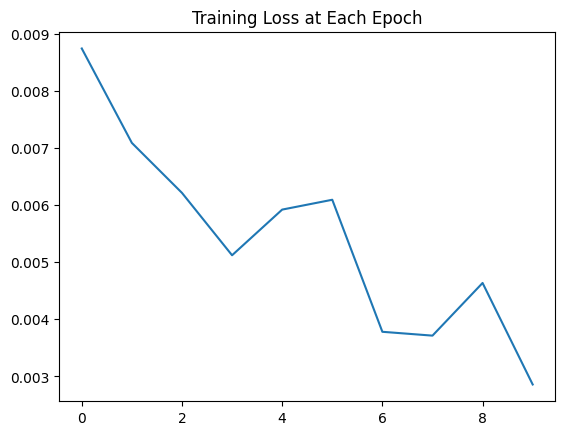

In [63]:
plt.plot(epochLosses)
plt.title("Training Loss at Each Epoch")


### Testing The Model

In [81]:
squeezenet.eval()

with torch.no_grad():
    testLoss = 0.0
    totalTestCorrect = 0
    totalYPred = []
    totalGroundTruth = []
    for inputs, labels in test_loader:
        yPred = squeezenet(inputs)
        loss = criterion(yPred, labels)
        testLoss += loss.item()
        
        predictedValues = torch.max(yPred.data,1)[1]
        batchCorrect = (predictedValues==labels).sum()
        
        totalYPred = totalYPred + predictedValues.tolist()
        totalGroundTruth = totalGroundTruth + labels.tolist()
        totalTestCorrect += batchCorrect
        
        
    print(f"Coorectly Classified {totalTestCorrect}/{len(test)}, Loss: {testLoss}")

Coorectly Classified 133/225, Loss: 5.188286066055298


In [71]:
from sklearn.metrics import classification_report, confusion_matrix

In [82]:
print(confusion_matrix(totalGroundTruth,totalYPred))

[[50  0  5  0]
 [ 4  0  0 35]
 [ 1  0 81  0]
 [ 7  0 40  2]]


In [84]:
print(classification_report(totalGroundTruth,totalYPred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.85        55
           1       0.00      0.00      0.00        39
           2       0.64      0.99      0.78        82
           3       0.05      0.04      0.05        49

    accuracy                           0.59       225
   macro avg       0.38      0.48      0.42       225
weighted avg       0.44      0.59      0.50       225



C:\Users\Lenovo\anaconda3\envs\dataml100\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\envs\dataml100\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\envs\dataml100\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion

We can see through confusion matrix and classification report of validtion set that our model is not working properly on class 1 and class 3 , and we need to work on it to increase our accuracy 